In [302]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import openpyxl
from sklearn.cluster import DBSCAN
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from numpy import sqrt
from statistics import mean

In [303]:
data = []

df = pd.read_excel('C:/Users/katya/OneDrive/Рабочий стол/_/НГТУ/8 семестр/КМ/файл_7.xlsx',index_col=None, header=None)
for i in range (0,len(df)):
    data.append(df.values[i][0])

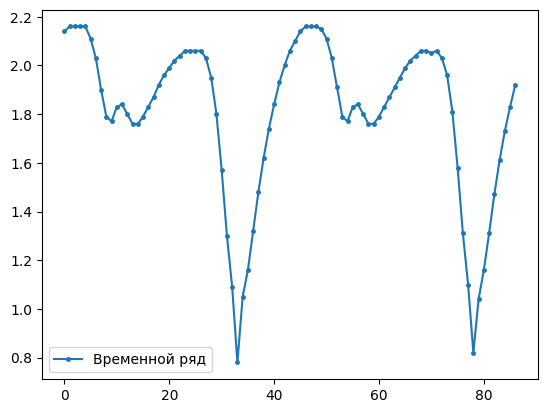

In [304]:
plt.plot(data, marker=".", markersize=5)
plt.legend(['Временной ряд'], loc=3)
plt.show()

In [305]:
# УДАЛЕНИЕ ВЫБРОСОВ

In [306]:
# z-оценка
def z_score(data):
    mean = np.mean(data)
    std = np.std(data)

    #outlier = []
    outlier_index = []
    for i in range(0,len(data)):
        z = (data[i] - mean) / std
        if z > 3 or z < -3:
            #outlier.append(data[i])
            outlier_index.append(i)
            
    return outlier_index

print('Поиск выбросов по z-оценкам')
print('Индексы выбросов:\n', z_score(data))

Поиск выбросов по z-оценкам
Индексы выбросов:
 [33, 78]


In [307]:
# Пространственная кластеризация
def dbscan(data_, eps=0.2):
    outlier_index = []
    
    data = np.array(data_).reshape(-1, 1)
    dbscan = DBSCAN(eps, min_samples=5, n_jobs=-1)
    clusters = dbscan.fit_predict(data)
    outliers = data[clusters == -1]

    for i in range(0,len(clusters)):
        if clusters[i] == -1:
            outlier_index.append(i)

    return outlier_index

print('Поиск выбросов по пространственной кластеризации')
outliers_data = dbscan(data, 0.2)
print('Индексы выбросов:\n', outliers_data)

Поиск выбросов по пространственной кластеризации
Индексы выбросов:
 [33, 78]


In [308]:
# Было принято решение выбросы не удалять

In [309]:
# ФИЛЬТРАЦИЯ ШУМА

# Статистика Бокса-Пирса
print('\nТестирование на наличие белого шума по статистике Бокса-Пирса')
result = sm.stats.diagnostic.acorr_ljungbox(data, lags=2, boxpierce=True)
print(result)


Тестирование на наличие белого шума по статистике Бокса-Пирса
      lb_stat     lb_pvalue     bp_stat     bp_pvalue
1   78.948223  6.375927e-19   76.287047  2.452876e-18
2  137.267025  1.558993e-30  131.984779  2.187104e-29


In [310]:
# Данные не являются белым шутом, нет необходимости производить фильтрацию

In [311]:
# Очистка данных от шума (Фильтр Калмана)
def Kalman(data, Q = 0.0001, R = 0.0001):
    # Начальные данные

    unfiltered_x = np.array(data)
    filtered_x = []
    filtered_x.append(unfiltered_x[0])  # устанавливаем начальное значение

    F = 1           # константа, описывающая динамику системы
    # Q = 0.0001    # шум процесса
    # R = 0.001     # шум измерения
    H = 1           # отношение между измерением и состоянием
    P = 1           # начальная оценка ошибки состояния

    length = len(unfiltered_x)

    for k in range(1, length):
        # Предсказание
        x_pred = F * filtered_x[k - 1]
        P = F * P * F + Q

        # Обновление коэффициента Калмана
        K = P * H /(H * P * H + R)

        # Обновление оценки состояния
        x_pred = x_pred + K * (unfiltered_x[k] - H * x_pred)
        filtered_x.append(x_pred)

        # Обновление P
        P = (1 - K * H) * P

    # Построение графиков
    plt.plot(unfiltered_x)
    plt.plot(filtered_x)
    plt.legend(['Начальные данные','Отфильтрованные данные'], loc=3)
    plt.show()

    return filtered_x


In [312]:
# Сглаживание значений ряда (алгоритм взвешенного скользящего среднего по 3 точкам)
def smoothing(data):
    data_new = []
    data_new.append(data[0])
    for i in range(1, len(data) - 1):
        data_new.append((data[i-1]+data[i]+data[i+1])/3.0)
    data_new.append(data[len(data) - 1])

    return data_new


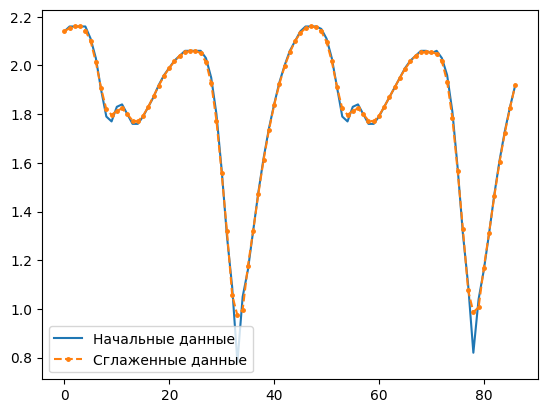

In [313]:
plt.plot(data)
data = smoothing(data)
plt.plot(data, linestyle='dashed', marker=".", markersize=5)
plt.legend(['Начальные данные','Сглаженные данные'], loc=3)
plt.show()

In [314]:
# Проверка на стационарность

In [315]:
# Тест Дикки-Фуддера
def adf_test(timeseries):

    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

# Тест Квятковского-Филлипса_Шмидта-Шина
def kpss_test(timeseries):

    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return kpss_output

In [316]:
print("\nРезультат ADF-теста:\n", adf_test(data))
print("\nРезультат KPSS-теста:\n", kpss_test(data))


Результат ADF-теста:
 Test Statistic                 -3.670378
p-value                         0.004550
#Lags Used                      7.000000
Number of Observations Used    79.000000
Critical Value (1%)            -3.515977
Critical Value (5%)            -2.898886
Critical Value (10%)           -2.586694
dtype: float64

Результат KPSS-теста:
 Test Statistic           0.174259
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\katya\AppData\Local\Temp\ipykernel_12828\1404950730.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [317]:
# Согласно обоим тестам ряд является стационарным

In [318]:
# Записываем обработанные данные
wb = openpyxl.Workbook() # Создаем книгу Excel
ws = wb.active # Выбираем активный лист

for index, value_ in enumerate(data, start=1):
    ws.cell(row=index, column=1, value=value_) # Добавляем данные
    
wb.save('C:\\Users\\katya\\OneDrive\\Рабочий стол\\_\\НГТУ\\8 семестр\\КМ\\новые_данные.xlsx') # Сохраняем книгу в файл